In [1]:
#Importing necessary dependencies
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.model_selection
import sklearn.linear_model
import sklearn.preprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, AlphaDropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [2]:
#Loading dataset
d1 = pd.read_csv('UNSW_NB15_training-set.csv')
t1 = pd.read_csv('UNSW_NB15_testing-set.csv')

In [3]:
data = d1.append(t1)

In [4]:
data.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,257673.000000,257673.000000,257673.000000,257673.000000,2.576730e+05,2.576730e+05,2.576730e+05,257673.000000,257673.000000,2.576730e+05,2.576730e+05,257673.000000,257673.000000,257673.000000,257673.000000,2.576730e+05,257673.000000,257673.000000,2.576730e+05,2.576730e+05,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,2.576730e+05,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000
mean,72811.823858,1.246715,19.777144,18.514703,8.572952e+03,1.438729e+04,9.125391e+04,180.000931,84.754957,7.060869e+07,6.582143e+05,4.889317,6.743691,912.300834,98.915462,5.419373e+03,582.251456,121.753661,1.006120e+09,1.002295e+09,119.254629,0.046038,0.023652,0.022386,137.639027,121.649703,0.102242,1.968900e+03,9.383176,1.324978,6.050467,5.238271,4.032677,8.322964,0.012819,0.012850,0.132005,6.800045,9.121049,0.014274,0.639077
std,48929.917641,5.974305,135.947152,111.985965,1.737739e+05,1.461993e+05,1.603446e+05,102.488268,112.762131,1.857313e+08,2.412372e+06,65.574953,53.702222,6922.153239,1094.048691,4.903450e+04,3930.153369,127.367443,1.367795e+09,1.363877e+09,127.230477,0.092908,0.053856,0.045771,205.901118,254.041013,0.710593,4.962523e+04,10.829706,0.992300,8.173749,8.160822,5.831515,11.120754,0.116091,0.116421,0.681854,8.396266,10.874752,0.118618,0.480269
min,1.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,32210.000000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,3.078928e+01,62.000000,0.000000,1.231800e+04,0.000000e+00,0.000000,0.000000,0.008000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000e+00,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
50%,64419.000000,0.004285,4.000000,2.000000,5.280000e+02,1.780000e+02,2.955665e+03,254.000000,29.000000,7.439423e+05,1.747441e+03,0.000000,0.000000,0.381696,0.007000,6.736370e-01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,73.000000,44.000000,0.000000,0.000000e+00,5.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,1.000000
75%,110923.000000,0.685777,12.000000,10.000000,1.362000e+03,1.064000e+03,1.250000e+05,254.000000,252.000000,8.000000e+07,2.210538e+04,3.000000,2.000000,58.094727,56.438859,2.787367e+03,119.712937,255.000000,2.007375e+09,1.992752e+09,255.000000,0.082082,0.036842,0.044665,100.000000,89.000000,0.000000,0.000000e+00,12.000000,2.000000,6.000000,4.000000,3.000000,8.000000,0.000000,0.000000,0.000000,8.000000,11.000000,0.000000,1.000000
max,175341.000000,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,2.242273e+07,5319.000000,5507.000000,84371.496000,57739.240000,1.483831e+06,463199.240100,255.000000,4.294959e+09,4.294882e+09,255.000000,3.821465,3.226788,2.928778,1504.000000,1500.000000,172.000000,6.558056e+06,63.000000,6.000000,59.000000,59.000000,46.000000,65.000000,4.000000,4.000000,30.000000,60.000000,62.000000,1.000000,1.000000


In [5]:
data

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,254,0,1.803636e+08,0.000000,0,0,0.011000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,254,0,8.810000e+08,0.000000,0,0,0.008000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,254,0,8.544000e+08,0.000000,0,0,0.005000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,254,0,6.000000e+08,0.000000,0,0,0.006000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,254,0,8.504000e+08,0.000000,0,0,0.010000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,24,2,24,24,13,24,0,0,0,24,24,0,Generic,1
175337,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,2,1,54.400111,66.98057,3721.068786,120.177727,255,3518776216,3453092386,255,0.09944,0.036895,0.062545,62,44,0,0,1,1,1,1,1,2,0,0,0,1,1,0,Shellcode,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,12,2,3,3,3,13,0,0,0,3,12,0,Generic,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,30,2,30,30,14,30,0,0,0,30,30,0,Generic,1


In [6]:
#Dropping attack category column since problem is binary classification
data.drop(columns = 'attack_cat', inplace = True)

In [7]:
#Dropping NaN values
data.dropna(inplace = True)

In [8]:
#Checking for null values in the dataset
data.isnull().sum().sum()

0

In [9]:
#Finding percentage of normal and attack classes where attack is represented by 1 and normal is represented by 0
nortr, attacktr = data['label'].value_counts()[0] / len(data.index), data['label'].value_counts()[1] / len(data.index)
#Displaying the percentage
print("Dataset contains {} % of normal classes and {} % of attack classes".format(nortr*100, attacktr*100))

Dataset contains 36.09225646458884 % of normal classes and 63.907743535411164 % of attack classes


In [10]:
data['service'].replace('-',np.nan,inplace=True)

In [11]:
data.isnull().sum()

id                        0
dur                       0
proto                     0
service              141321
state                     0
spkts                     0
dpkts                     0
sbytes                    0
dbytes                    0
rate                      0
sttl                      0
dttl                      0
sload                     0
dload                     0
sloss                     0
dloss                     0
sinpkt                    0
dinpkt                    0
sjit                      0
djit                      0
swin                      0
stcpb                     0
dtcpb                     0
dwin                      0
tcprtt                    0
synack                    0
ackdat                    0
smean                     0
dmean                     0
trans_depth               0
response_body_len         0
ct_srv_src                0
ct_state_ttl              0
ct_dst_ltm                0
ct_src_dport_ltm          0
ct_dst_sport_ltm    

In [12]:
data.dropna(inplace=True)

In [13]:
data.shape

(116352, 44)

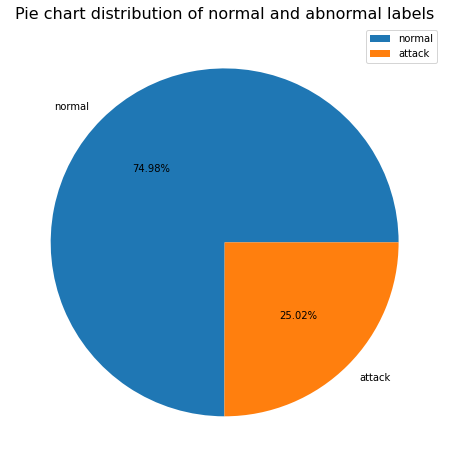

In [14]:
plt.figure(figsize=(8,8))
plt.pie(data.label.value_counts(),labels=['normal','attack'],autopct='%0.2f%%')
plt.title("Pie chart distribution of normal and abnormal labels",fontsize=16)
plt.legend()
plt.show()

In [15]:
data['label'].value_counts()

1    87239
0    29113
Name: label, dtype: int64

In [16]:
label_feature = ['label']
categorical_features = ['proto', 'service', 'state']
drop_features = ['id', 'sttl', 'dttl', 'swin', 'dwin', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat']
numerical_features = list(set(data.columns) - set(label_feature) - set(categorical_features) - set(drop_features))

In [17]:
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [18]:
data

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
35,36,1.639803e-02,tcp,http,FIN,0.000845,0.000726,0.000052,0.000080,0.000017,62,252,0.000003,0.000372,0.000376,0.000363,7.812870e-03,0.008929,0.005354,0.000416,255,0.184907,0.378310,255,0.138574,0.211241,0.068943,0.029367,0.098000,1,184,2,1,1,1,1,2,0,0,1,1,3,0,0
40,41,2.558777e-02,tcp,http,FIN,0.000845,0.000908,0.000053,0.000086,0.000012,62,252,0.000002,0.000265,0.000376,0.000363,1.218406e-02,0.011368,0.010775,0.000527,255,0.164944,0.731456,255,0.120962,0.201924,0.053864,0.030120,0.084667,1,187,2,1,1,1,1,2,0,0,1,1,3,0,0
45,46,1.765612e-02,tcp,http,FIN,0.000845,0.000726,0.000053,0.000077,0.000016,62,252,0.000002,0.000334,0.000376,0.000363,8.412291e-03,0.009498,0.005510,0.000552,255,0.431594,0.279972,255,0.184401,0.250346,0.102824,0.030120,0.094667,1,165,1,1,1,1,1,1,0,0,1,3,1,0,0
49,50,1.650926e-02,tcp,http,FIN,0.000845,0.000908,0.000051,0.000096,0.000019,62,252,0.000003,0.000459,0.000376,0.000363,7.865868e-03,0.007191,0.006477,0.000310,255,0.355943,0.248345,255,0.121715,0.164188,0.068250,0.027861,0.094000,1,261,2,1,18,1,1,2,0,0,1,1,2,0,0
72,73,2.172547e-02,tcp,http,FIN,0.001033,0.000726,0.000058,0.000076,0.000015,62,252,0.000002,0.000268,0.000376,0.000363,8.469114e-03,0.012540,0.005862,0.000545,255,0.275418,0.186876,255,0.093957,0.145208,0.046032,0.024096,0.093333,1,157,1,1,1,1,1,1,0,0,1,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175335,175336,1.000008e-07,udp,dns,INT,0.000094,0.000000,0.000003,0.000000,0.166667,254,0,0.032986,0.000000,0.000000,0.000000,4.288100e-07,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.010542,0.000000,0,0,45,2,33,33,17,45,0,0,0,33,45,0,1
175336,175337,1.500012e-07,udp,dns,INT,0.000094,0.000000,0.000003,0.000000,0.111111,254,0,0.021991,0.000000,0.000000,0.000000,6.432150e-07,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.010542,0.000000,0,0,24,2,24,24,13,24,0,0,0,24,24,0,1
175338,175339,1.500012e-07,udp,dns,INT,0.000094,0.000000,0.000003,0.000000,0.111111,254,0,0.021991,0.000000,0.000000,0.000000,6.432150e-07,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.010542,0.000000,0,0,12,2,3,3,3,13,0,0,0,3,12,0,1
175339,175340,1.500012e-07,udp,dns,INT,0.000094,0.000000,0.000003,0.000000,0.111111,254,0,0.021991,0.000000,0.000000,0.000000,6.432150e-07,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.010542,0.000000,0,0,30,2,30,30,14,30,0,0,0,30,30,0,1


In [19]:
serv = OneHotEncoder()
pro = OneHotEncoder()
sta = OneHotEncoder()

def encode(data):

    X = serv.fit_transform(data['service'].values.reshape(-1, 1))
    X2 = pro.fit_transform(data['proto'].values.reshape(-1, 1))
    X3 = sta.fit_transform(data['state'].values.reshape(-1, 1))

    data = pd.concat([data,
                      pd.DataFrame(X2.toarray(), columns=['proto_'+i for i in pro.categories_[0]]),
                      pd.DataFrame(X.toarray(), columns=['service_'+i for i in serv.categories_[0]]),
                      pd.DataFrame(X3.toarray(), columns=['state_'+i for i in sta.categories_[0]])],
                      axis=1)

    data.drop(['proto', 'service', 'state'], axis=1, inplace=True)

    return data

In [20]:
data.reset_index(drop=True)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,36,1.639803e-02,tcp,http,FIN,0.000845,0.000726,0.000052,0.000080,0.000017,62,252,0.000003,0.000372,0.000376,0.000363,7.812870e-03,0.008929,0.005354,0.000416,255,0.184907,0.378310,255,0.138574,0.211241,0.068943,0.029367,0.098000,1,184,2,1,1,1,1,2,0,0,1,1,3,0,0
1,41,2.558777e-02,tcp,http,FIN,0.000845,0.000908,0.000053,0.000086,0.000012,62,252,0.000002,0.000265,0.000376,0.000363,1.218406e-02,0.011368,0.010775,0.000527,255,0.164944,0.731456,255,0.120962,0.201924,0.053864,0.030120,0.084667,1,187,2,1,1,1,1,2,0,0,1,1,3,0,0
2,46,1.765612e-02,tcp,http,FIN,0.000845,0.000726,0.000053,0.000077,0.000016,62,252,0.000002,0.000334,0.000376,0.000363,8.412291e-03,0.009498,0.005510,0.000552,255,0.431594,0.279972,255,0.184401,0.250346,0.102824,0.030120,0.094667,1,165,1,1,1,1,1,1,0,0,1,3,1,0,0
3,50,1.650926e-02,tcp,http,FIN,0.000845,0.000908,0.000051,0.000096,0.000019,62,252,0.000003,0.000459,0.000376,0.000363,7.865868e-03,0.007191,0.006477,0.000310,255,0.355943,0.248345,255,0.121715,0.164188,0.068250,0.027861,0.094000,1,261,2,1,18,1,1,2,0,0,1,1,2,0,0
4,73,2.172547e-02,tcp,http,FIN,0.001033,0.000726,0.000058,0.000076,0.000015,62,252,0.000002,0.000268,0.000376,0.000363,8.469114e-03,0.012540,0.005862,0.000545,255,0.275418,0.186876,255,0.093957,0.145208,0.046032,0.024096,0.093333,1,157,1,1,1,1,1,1,0,0,1,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116347,175336,1.000008e-07,udp,dns,INT,0.000094,0.000000,0.000003,0.000000,0.166667,254,0,0.032986,0.000000,0.000000,0.000000,4.288100e-07,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.010542,0.000000,0,0,45,2,33,33,17,45,0,0,0,33,45,0,1
116348,175337,1.500012e-07,udp,dns,INT,0.000094,0.000000,0.000003,0.000000,0.111111,254,0,0.021991,0.000000,0.000000,0.000000,6.432150e-07,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.010542,0.000000,0,0,24,2,24,24,13,24,0,0,0,24,24,0,1
116349,175339,1.500012e-07,udp,dns,INT,0.000094,0.000000,0.000003,0.000000,0.111111,254,0,0.021991,0.000000,0.000000,0.000000,6.432150e-07,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.010542,0.000000,0,0,12,2,3,3,3,13,0,0,0,3,12,0,1
116350,175340,1.500012e-07,udp,dns,INT,0.000094,0.000000,0.000003,0.000000,0.111111,254,0,0.021991,0.000000,0.000000,0.000000,6.432150e-07,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.010542,0.000000,0,0,30,2,30,30,14,30,0,0,0,30,30,0,1


In [21]:
data.shape

(116352, 44)

In [22]:
catval = ['proto', 'service', 'state']
data_cat = data[catval].copy()
data_cat.head()

,proto,service,state
35,tcp,http,FIN
40,tcp,http,FIN
45,tcp,http,FIN
49,tcp,http,FIN
72,tcp,http,FIN


In [23]:
data_cat = pd.get_dummies(data_cat,columns=catval)
data = pd.concat([data, data_cat],axis=1)

In [24]:
data.drop(columns=catval,inplace=True)

In [25]:
data

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,proto_tcp,proto_udp,service_dhcp,service_dns,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,state_ACC,state_CON,state_FIN,state_INT,state_REQ,state_RST
35,36,1.639803e-02,0.000845,0.000726,0.000052,0.000080,0.000017,62,252,0.000003,0.000372,0.000376,0.000363,7.812870e-03,0.008929,0.005354,0.000416,255,0.184907,0.378310,255,0.138574,0.211241,0.068943,0.029367,0.098000,1,184,2,1,1,1,1,2,0,0,1,1,3,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
40,41,2.558777e-02,0.000845,0.000908,0.000053,0.000086,0.000012,62,252,0.000002,0.000265,0.000376,0.000363,1.218406e-02,0.011368,0.010775,0.000527,255,0.164944,0.731456,255,0.120962,0.201924,0.053864,0.030120,0.084667,1,187,2,1,1,1,1,2,0,0,1,1,3,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
45,46,1.765612e-02,0.000845,0.000726,0.000053,0.000077,0.000016,62,252,0.000002,0.000334,0.000376,0.000363,8.412291e-03,0.009498,0.005510,0.000552,255,0.431594,0.279972,255,0.184401,0.250346,0.102824,0.030120,0.094667,1,165,1,1,1,1,1,1,0,0,1,3,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
49,50,1.650926e-02,0.000845,0.000908,0.000051,0.000096,0.000019,62,252,0.000003,0.000459,0.000376,0.000363,7.865868e-03,0.007191,0.006477,0.000310,255,0.355943,0.248345,255,0.121715,0.164188,0.068250,0.027861,0.094000,1,261,2,1,18,1,1,2,0,0,1,1,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
72,73,2.172547e-02,0.001033,0.000726,0.000058,0.000076,0.000015,62,252,0.000002,0.000268,0.000376,0.000363,8.469114e-03,0.012540,0.005862,0.000545,255,0.275418,0.186876,255,0.093957,0.145208,0.046032,0.024096,0.093333,1,157,1,1,1,1,1,1,0,0,1,2,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175335,175336,1.000008e-07,0.000094,0.000000,0.000003,0.000000,0.166667,254,0,0.032986,0.000000,0.000000,0.000000,4.288100e-07,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.010542,0.000000,0,0,45,2,33,33,17,45,0,0,0,33,45,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
175336,175337,1.500012e-07,0.000094,0.000000,0.000003,0.000000,0.111111,254,0,0.021991,0.000000,0.000000,0.000000,6.432150e-07,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.010542,0.000000,0,0,24,2,24,24,13,24,0,0,0,24,24,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
175338,175339,1.500012e-07,0.000094,0.000000,0.000003,0.000000,0.111111,254,0,0.021991,0.000000,0.000000,0.000000,6.432150e-07,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.010542,0.000000,0,0,12,2,3,3,3,13,0,0,0,3,12,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
175339,175340,1.500012e-07,0.000094,0.000000,0.000003,0.000000,0.111111,254,0,0.021991,0.000000,0.000000,0.000000,6.432150e-07,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.010542,0.000000,0,0,30,2,30,30,14,30,0,0,0,30,30,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [26]:
train, val = train_test_split(data, test_size=0.2)

In [27]:
X = train.drop(columns=['label'],axis=1)
Y = train['label']

In [28]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.20, random_state=50)

In [29]:
#ANOVA Feature selection
def select_features(X_train, y_train, X_test):
	# configure to select a subset of features
	fs = SelectKBest(score_func=f_classif, k=15)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [30]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [39 54] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [31]:
class FalsePositiveRate(tf.keras.metrics.Metric):
    def __init__(self, name='false_positive_rate', **kwargs):
        super(FalsePositiveRate, self).__init__(name=name, **kwargs)
        self.negatives = self.add_weight(name='negatives', initializer='zeros')
        self.false_positives = self.add_weight(name='false_negatives', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.bool)
        
        negatives = tf.reduce_sum(tf.cast(tf.equal(y_true, False), self.dtype))
        
        self.negatives.assign_add(negatives)
        
        y_pred = tf.greater_equal(y_pred, 0.5)
        
        false_positive_values = tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True)) 
        false_positive_values = tf.cast(false_positive_values, self.dtype)
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self.dtype)
            sample_weight = tf.broadcast_weights(sample_weight, values)
            values = tf.multiply(false_positive_values, sample_weight)
        
        false_positives = tf.reduce_sum(false_positive_values)
        
        self.false_positives.assign_add(false_positives)
        
    def result(self):
        return tf.divide(self.false_positives, self.negatives)

In [32]:
def plot_loss(model_history):
  train_loss=[value for key, value in model_history.items() if 'loss' in key.lower()][0]
  valid_loss=[value for key, value in model_history.items() if 'loss' in key.lower()][1]
  fig, ax1 = plt.subplots()
  color = 'tab:blue'
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss', color=color)
  ax1.plot(train_loss, '--', color=color, label='Train Loss')
  ax1.plot(valid_loss, color=color, label='Valid Loss')
  ax1.tick_params(axis='y', labelcolor=color)
  plt.legend(loc='upper left')
  plt.title('Model Loss')
  plt.show()

def plot_model_recall_fpr(model_history):
  train_recall=[value for key, value in model_history.items() if 'recall' in key.lower()][0]
  valid_recall=[value for key, value in model_history.items() if 'recall' in key.lower()][1]
  train_fpr=[value for key, value in model_history.items() if 'false_positive_rate' in key.lower()][0]
  valid_fpr=[value for key, value in model_history.items() if 'false_positive_rate' in key.lower()][1]
  fig, ax1 = plt.subplots()
  color = 'tab:red'
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Recall', color=color)
  ax1.set_ylim([-0.05,1.05])
  ax1.plot(train_recall, '--', color=color, label='Train Recall')
  ax1.plot(valid_recall, color=color, label='Valid Recall')
  ax1.tick_params(axis='y', labelcolor=color)
  plt.legend(loc='upper left')
  plt.title('Model Recall and FPR')
  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
  color = 'tab:blue'
  ax2.set_ylabel('False Positive Rate', color=color)  # we already handled the x-label with ax1
  ax2.plot(train_fpr, '--', color=color, label='Train FPR')
  ax2.plot(valid_fpr, color=color, label='Valid FPR')
  ax2.tick_params(axis='y', labelcolor=color)
  ax2.set_ylim([-0.05,1.05])
  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.legend(loc='upper right')
  plt.show()

In [73]:
mlp = Sequential()
mlp.add(Dense(units=128, input_dim=X_train_fs.shape[1], activation='relu'))
mlp.add(Dense(256, activation='relu'))
mlp.add(Dense(256, activation='relu'))
mlp.add(Dense(256, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))
mlp.summary()
mlp.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', FalsePositiveRate(), tf.keras.metrics.Recall()]
           )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               2048      
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dense_11 (Dense)            (None, 256)               65792     
                                                                 
 dense_12 (Dense)            (None, 1)                 257       
                                                                 
Total params: 166,913
Trainable params: 166,913
Non-trainable params: 0
_________________________________________________________________


In [82]:
history = mlp.fit(x=X_train_fs,
                  y=y_train,
                  batch_size=1000,
                  epochs=95,validation_split = 0.2,
                  verbose=0).history

In [83]:
test_results = mlp.evaluate(X_test_fs, y_test, verbose=1)
print(f'Test results -  Accuracy: {test_results[1]*100}')

582/582 [==============================] - 1s 2ms/step - loss: 0.1043 - accuracy: 0.9643 - false_positive_rate: 0.1407 - recall_3: 0.9995
Test results -  Accuracy: 96.43336534500122


In [84]:
print(f'Test results -  Accuracy: {test_results[1]*100}')

Test results -  Accuracy: 96.43336534500122


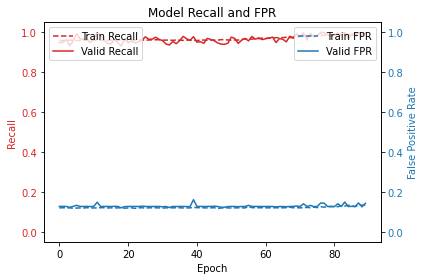

In [85]:
plot_model_recall_fpr(history)

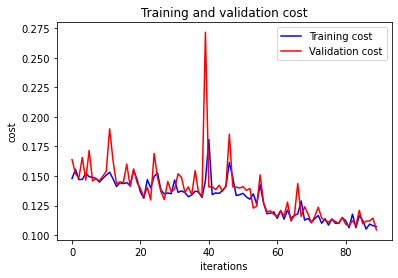

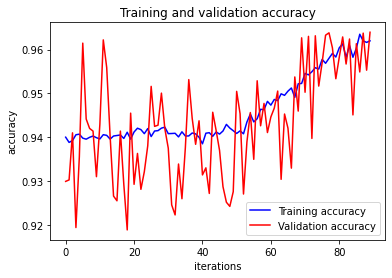

In [87]:
import matplotlib.pyplot as plt

def plot_train_history(history):
    # plot the cost and accuracy 
    loss_list = history['loss']
    val_loss_list = history['val_loss']
    accuracy_list = history['accuracy']
    val_accuracy_list = history['val_accuracy']
    # epochs = range(len(loss_list))

    # plot the cost
    plt.plot(loss_list, 'b', label='Training cost')
    plt.plot(val_loss_list, 'r', label='Validation cost')
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title('Training and validation cost')
    plt.legend()

    plt.figure()
    
    # plot the accuracy
    plt.plot(accuracy_list, 'b', label='Training accuracy')
    plt.plot(val_accuracy_list, 'r', label='Validation accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('iterations')
    plt.title('Training and validation accuracy')
    plt.legend()

plot_train_history(history)